In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import enum
from Py.BS import TypeOptionVanilla
import pandas as pd
from Py.Market import *
from Py.ResultSimulation import *
from Py.BlackScholes import *
from Py.Heston import *
from Py.CalibrationProduct import *
from Py.AutocallProduct import *

from Py.AutocallPricer import *
from Py.MCSensi import *

### Create Market

In [3]:
spot = 100
marketObj = Market(spot)
marketObj.initBlack(r= 0.00,repo = 0.000,vol = 0.2)

marketStressed = Market(spot)
marketStressed.initBlack(r= 0.00,repo = 0.000,vol = 0.6)

### Create Model for Pricing

In [4]:
hestonObj = Heston(marketObj,rho = -0.7,Vo = 0.2,nu=0.7)
bsModel = BlackScholesModel(marketObj,sigma= 0.2)
bsModelStressed = BlackScholesModel(marketStressed,sigma= marketStressed.getVol(100,1)) 

##### Set For calibration

In [7]:
listK = [90,100,110,120]
listT = [5]
So = 100
listCalibrationProducts = []

for K in listK:
    
    sens = 1 if K <=So else -1
    for T in listT:        
        listCalibrationProducts.append(VanillaProduct(K,T,marketObj,sens))

In [15]:
hestonObj.calibrate(listCalibrationProducts,verbose=1)

The maximum number of function evaluations is exceeded.
Number of iterations: 1000, function evaluations: 6816, CG iterations: 1901, optimality: 3.69e-06, constraint violation: 0.00e+00, execution time: 1.1e+02 s.


In [17]:
hestonObj.printParams()

{'kappa': 3.9731322078758473,
 'theta': 0.025273510894741953,
 'Vo': 0.31893296155831685,
 'nu': 0.13340523614775804,
 'rho': -0.003288653021645551}

##### Check Calibration

In [18]:
model = hestonObj

In [19]:
[((model.modelPrice(u)-u.value)/u.value)*10000 for u in listCalibrationProducts]

[0.2410414426340739,
 -0.31235333665801357,
 -0.1992634673765191,
 0.17388210966381523]

### Create Autocall product and Price

##### Case Product degenerates to DIP without AC

In [5]:
spotRef=100
maturity=2
acBarrierLevel=9999
coupon=0
cpnBarrier=9999
dipStrike=1
dipBarrier=0.8
isDipAmerican=True
cpnFrequency=Frequency.Annualy
isIncrementalFeature = False
isPhoenixMemory = False
nominal = 100
hasRedemption = False

In [6]:
autocallProduct = AutocallProduct(spotRef=spotRef,maturity=maturity,acBarrierLevel=acBarrierLevel,coupon=coupon,cpnBarrier=cpnBarrier,
                                  dipStrike=dipStrike,dipBarrier=dipBarrier,isDipAmerican=isDipAmerican,cpnFrequency=cpnFrequency,isIncrementalFeature = isIncrementalFeature,
                                isPhoenixMemory = isPhoenixMemory,Nominal=nominal,hasRedemption = hasRedemption )

In [7]:
Npaths = 50000
modelPaths = bsModel.generate_paths(maturity,Npaths=Npaths,listT=autocallProduct.counponsSimulDates(), isAntithetic=False,discretStep=Frequency.Monthly)

In [8]:
autocallPricer = AutocallPricer(autocallProduct,modelPaths,marketObj.discount)

In [9]:
priceDipWithoutAC = (1-(autocallPricer.price/nominal))*nominal

In [10]:
priceDipWithoutAC

9.696696837840602

0.01 is being treated
0.02 is being treated
0.05 is being treated
0.1 is being treated
0.3 is being treated
0.5 is being treated
0.7 is being treated
1.0 is being treated
1.2 is being treated
1.4 is being treated
1.7 is being treated
1.8 is being treated
1.9 is being treated
2 is being treated
2.1 is being treated
2.2 is being treated
2.5 is being treated
3 is being treated
3.5 is being treated
4 is being treated
237.6719138622284


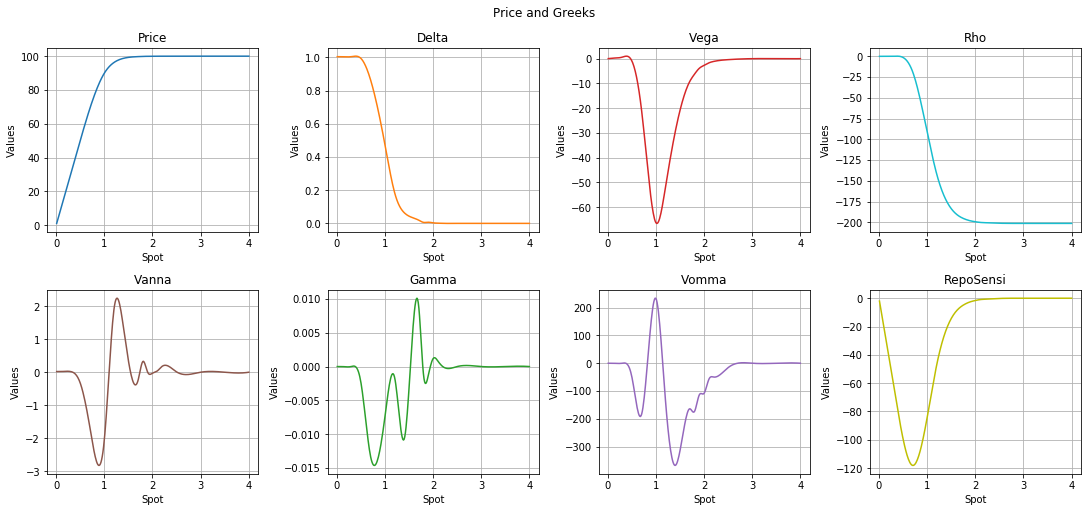

In [11]:
sensiEngine = GenerateMCSensi(autocallProduct,AutocallPricer,bsModel,nbSim = 5000,discretStep=Frequency.TriDaily)
resSensi = sensiEngine.runPriceAndGreeks(listSpots=[0.01,0.02,0.05,0.1,0.3,0.5, 0.7, 1.0,1.2,1.4,1.7,1.8,1.9,2,2.1,2.2,2.5,3,3.5,4])
mcSensiPlot(resSensi)

##### Case Product full AC with AC barrier not so far from spot

0.01 is being treated
0.02 is being treated
0.05 is being treated
0.1 is being treated
0.3 is being treated
0.5 is being treated
0.7 is being treated
1.0 is being treated
1.2 is being treated
1.4 is being treated
1.7 is being treated
1.8 is being treated
1.9 is being treated
2 is being treated
2.1 is being treated
2.2 is being treated
2.5 is being treated
3 is being treated
3.5 is being treated
4 is being treated
500.4580936431885


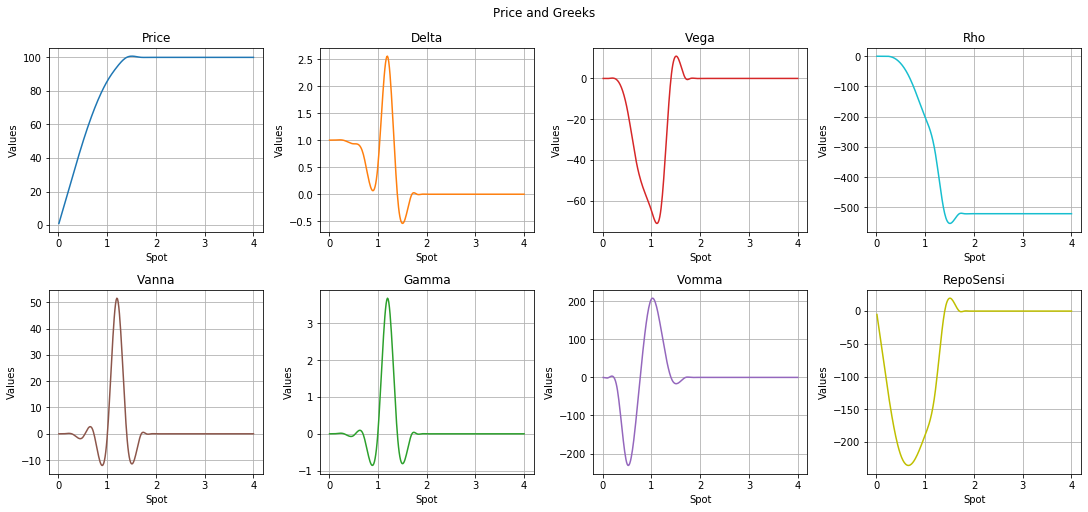

In [12]:
spotRef=100
maturity=5
acBarrierLevel=1.2
coupon=0.02
cpnBarrier=1.10
dipStrike=1
dipBarrier=0.9
isDipAmerican=True
cpnFrequency=Frequency.Annualy
isIncrementalFeature = False
isPhoenixMemory = False
nominal = 100
hasRedemption = False

autocallProduct = AutocallProduct(spotRef=spotRef,maturity=maturity,acBarrierLevel=acBarrierLevel,coupon=coupon,cpnBarrier=cpnBarrier,
                                  dipStrike=dipStrike,dipBarrier=dipBarrier,isDipAmerican=isDipAmerican,cpnFrequency=cpnFrequency,isIncrementalFeature = isIncrementalFeature,
                                isPhoenixMemory = isPhoenixMemory,Nominal=nominal,hasRedemption = hasRedemption )

sensiEngine = GenerateMCSensi(autocallProduct,AutocallPricer,bsModel,nbSim = 5000,discretStep = Frequency.TriDaily)
resSensi = sensiEngine.runPriceAndGreeks(listSpots=[0.01,0.02,0.05,0.1,0.3,0.5, 0.7, 1.0,1.2,1.4,1.7,1.8,1.9,2,2.1,2.2,2.5,3,3.5,4])
mcSensiPlot(resSensi)

##### Case Product full AC with AC barrier not so far from spot but no PDI

0.01 is being treated
0.02 is being treated
0.05 is being treated
0.1 is being treated
0.3 is being treated
0.5 is being treated
0.7 is being treated
1.0 is being treated
1.2 is being treated
1.4 is being treated
1.7 is being treated
1.8 is being treated
1.9 is being treated
2 is being treated
2.1 is being treated
2.2 is being treated
2.5 is being treated
3 is being treated
3.5 is being treated
4 is being treated
388.0625741481781


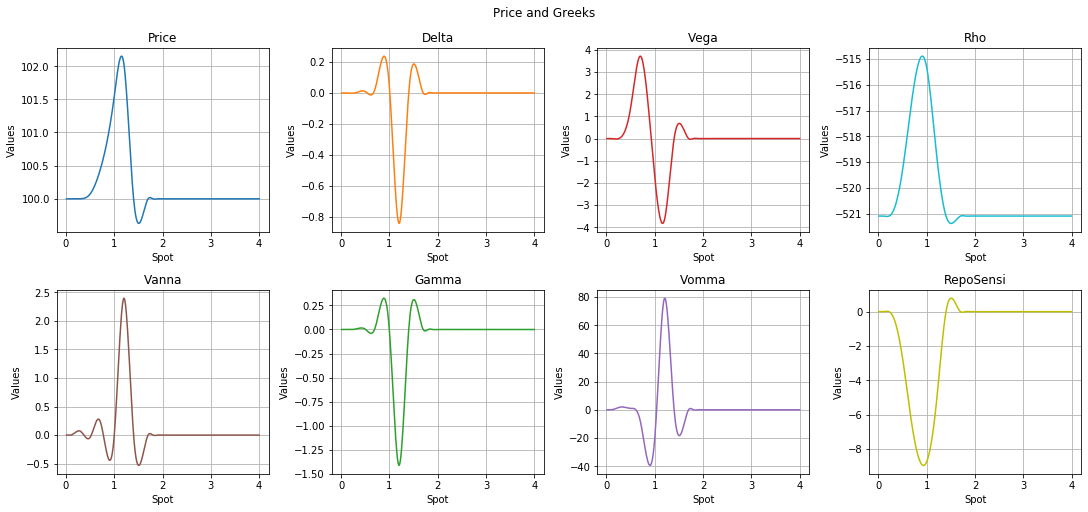

In [13]:
spotRef=100
maturity=5
acBarrierLevel=1.2
coupon=0.02
cpnBarrier=1.10
dipStrike=1
dipBarrier=0
isDipAmerican=False
cpnFrequency=Frequency.Annualy
isIncrementalFeature = False
isPhoenixMemory = False
nominal = 100
hasRedemption = False

autocallProduct = AutocallProduct(spotRef=spotRef,maturity=maturity,acBarrierLevel=acBarrierLevel,coupon=coupon,cpnBarrier=cpnBarrier,
                                  dipStrike=dipStrike,dipBarrier=dipBarrier,isDipAmerican=isDipAmerican,cpnFrequency=cpnFrequency,isIncrementalFeature = isIncrementalFeature,
                                isPhoenixMemory = isPhoenixMemory,Nominal=nominal,hasRedemption = hasRedemption )

sensiEngine = GenerateMCSensi(autocallProduct,AutocallPricer,bsModel,nbSim = 5000,discretStep = Frequency.TriDaily)
resSensi = sensiEngine.runPriceAndGreeks(listSpots=[0.01,0.02,0.05,0.1,0.3,0.5, 0.7, 1.0,1.2,1.4,1.7,1.8,1.9,2,2.1,2.2,2.5,3,3.5,4])
mcSensiPlot(resSensi)

##### Case Product full AC with AC barrier far from spot

0.01 is being treated
0.02 is being treated
0.05 is being treated
0.1 is being treated
0.3 is being treated
0.5 is being treated
0.7 is being treated
1.0 is being treated
1.2 is being treated
1.4 is being treated
1.7 is being treated
1.8 is being treated
1.9 is being treated
2 is being treated
2.1 is being treated
2.2 is being treated
2.5 is being treated
3 is being treated
3.5 is being treated
4 is being treated
435.10431814193726


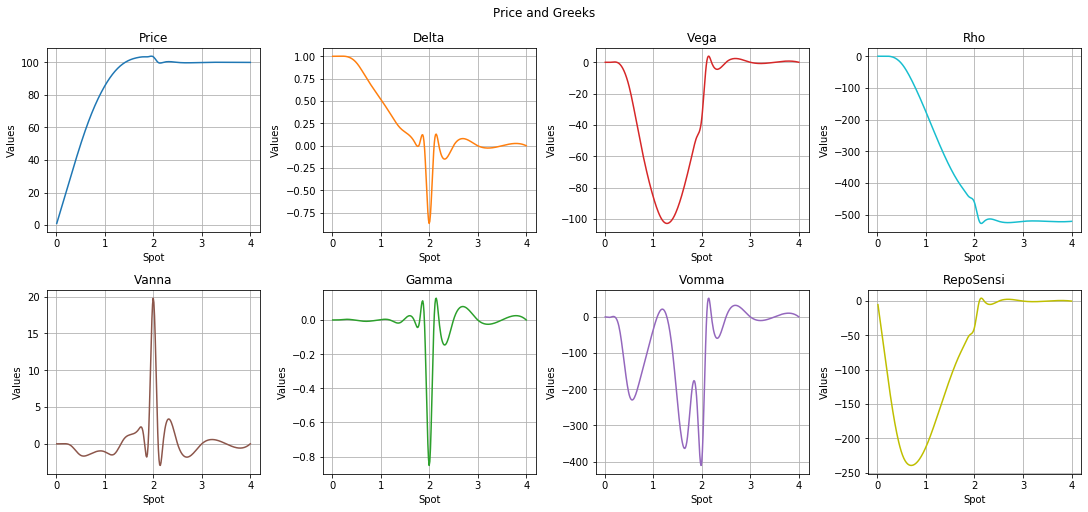

In [14]:
spotRef=100
maturity=5
acBarrierLevel=2
coupon=0.02
cpnBarrier=1.10
dipStrike=1
dipBarrier=0.9
isDipAmerican=True
cpnFrequency=Frequency.Annualy
isIncrementalFeature = False
isPhoenixMemory = False
nominal = 100
hasRedemption = False

autocallProduct = AutocallProduct(spotRef=spotRef,maturity=maturity,acBarrierLevel=acBarrierLevel,coupon=coupon,cpnBarrier=cpnBarrier,
                                  dipStrike=dipStrike,dipBarrier=dipBarrier,isDipAmerican=isDipAmerican,cpnFrequency=cpnFrequency,isIncrementalFeature = isIncrementalFeature,
                                isPhoenixMemory = isPhoenixMemory,Nominal=nominal,hasRedemption = hasRedemption )

sensiEngine = GenerateMCSensi(autocallProduct,AutocallPricer,bsModel,nbSim = 5000,discretStep = Frequency.TriDaily)
resSensi = sensiEngine.runPriceAndGreeks(listSpots=[0.01,0.02,0.05,0.1,0.3,0.5, 0.7, 1.0,1.2,1.4,1.7,1.8,1.9,2,2.1,2.2,2.5,3,3.5,4])
mcSensiPlot(resSensi)

##### Case Product full AC with AC barrier not so far from spot but with Huge coupon

0.01 is being treated
0.02 is being treated
0.05 is being treated
0.1 is being treated
0.3 is being treated
0.5 is being treated
0.7 is being treated
1.0 is being treated
1.2 is being treated
1.4 is being treated
1.7 is being treated
1.8 is being treated
1.9 is being treated
2 is being treated
2.1 is being treated
2.2 is being treated
2.5 is being treated
3 is being treated
3.5 is being treated
4 is being treated
442.34152388572693


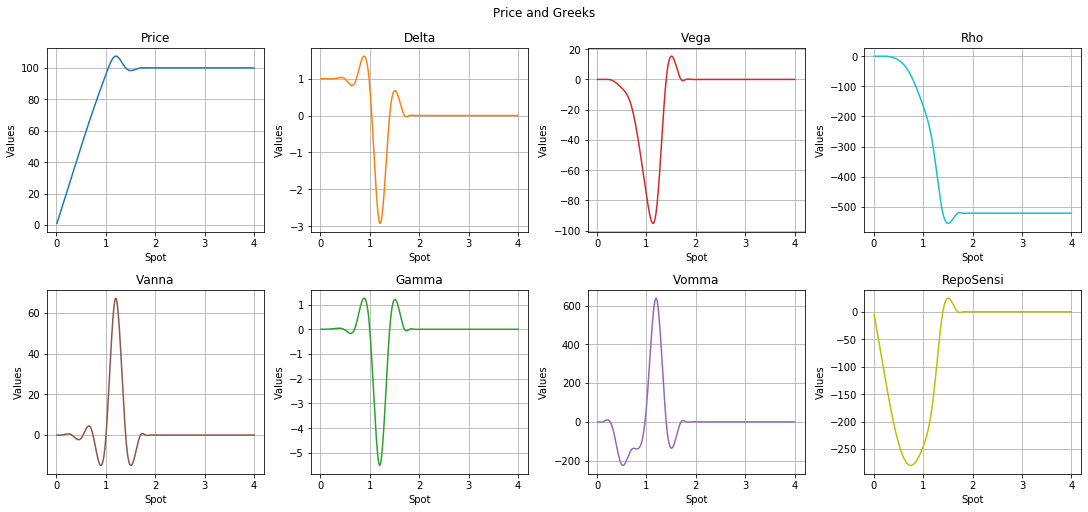

In [15]:
spotRef=100
maturity=5
acBarrierLevel=1.2
coupon=0.15
cpnBarrier=1.10
dipStrike=1
dipBarrier=0.9
isDipAmerican=True
cpnFrequency=Frequency.Annualy
isIncrementalFeature = False
isPhoenixMemory = False
nominal = 100
hasRedemption = False

autocallProduct = AutocallProduct(spotRef=spotRef,maturity=maturity,acBarrierLevel=acBarrierLevel,coupon=coupon,cpnBarrier=cpnBarrier,
                                  dipStrike=dipStrike,dipBarrier=dipBarrier,isDipAmerican=isDipAmerican,cpnFrequency=cpnFrequency,isIncrementalFeature = isIncrementalFeature,
                                isPhoenixMemory = isPhoenixMemory,Nominal=nominal,hasRedemption = hasRedemption )

sensiEngine = GenerateMCSensi(autocallProduct,AutocallPricer,bsModel,nbSim = 5000,discretStep = Frequency.TriDaily)
resSensi = sensiEngine.runPriceAndGreeks(listSpots=[0.01,0.02,0.05,0.1,0.3,0.5, 0.7, 1.0,1.2,1.4,1.7,1.8,1.9,2,2.1,2.2,2.5,3,3.5,4])
mcSensiPlot(resSensi)

#### Case DIP European with Huge coupon

0.01 is being treated
0.02 is being treated
0.05 is being treated
0.1 is being treated
0.3 is being treated
0.5 is being treated
0.7 is being treated
1.0 is being treated
1.2 is being treated
1.4 is being treated
1.7 is being treated
1.8 is being treated
1.9 is being treated
2 is being treated
2.1 is being treated
2.2 is being treated
2.5 is being treated
3 is being treated
3.5 is being treated
4 is being treated
383.3610236644745


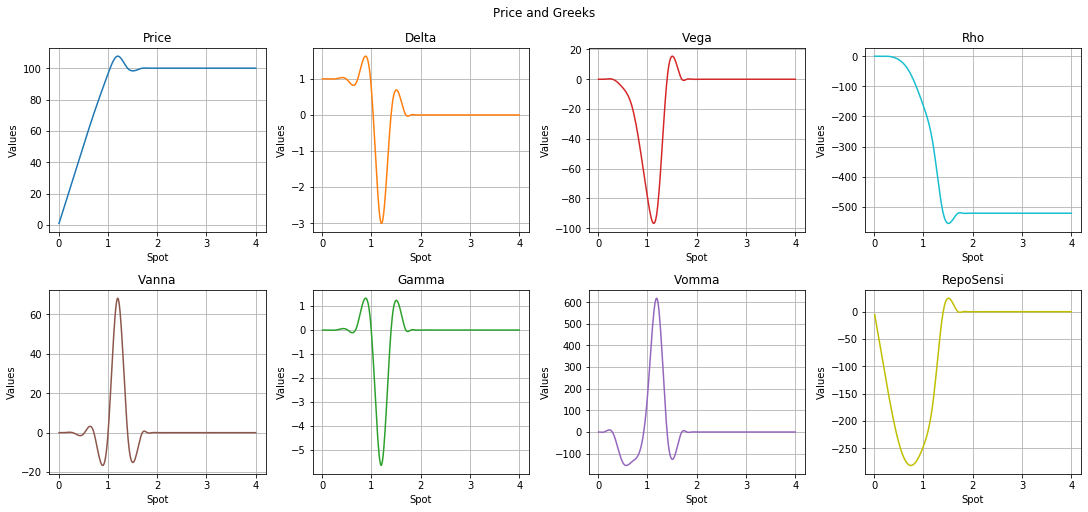

In [16]:
spotRef=100
maturity=5
acBarrierLevel=1.2
coupon=0.15
cpnBarrier=1.10
dipStrike=1
dipBarrier=0.9
isDipAmerican=False
cpnFrequency=Frequency.Annualy
isIncrementalFeature = False
isPhoenixMemory = False
nominal = 100
hasRedemption = False

autocallProduct = AutocallProduct(spotRef=spotRef,maturity=maturity,acBarrierLevel=acBarrierLevel,coupon=coupon,cpnBarrier=cpnBarrier,
                                  dipStrike=dipStrike,dipBarrier=dipBarrier,isDipAmerican=isDipAmerican,cpnFrequency=cpnFrequency,isIncrementalFeature = isIncrementalFeature,
                                isPhoenixMemory = isPhoenixMemory,Nominal=nominal,hasRedemption = hasRedemption )

sensiEngine = GenerateMCSensi(autocallProduct,AutocallPricer,bsModel,nbSim = 5000,discretStep = Frequency.TriDaily)
resSensi = sensiEngine.runPriceAndGreeks(listSpots=[0.01,0.02,0.05,0.1,0.3,0.5, 0.7, 1.0,1.2,1.4,1.7,1.8,1.9,2,2.1,2.2,2.5,3,3.5,4])
mcSensiPlot(resSensi)

#### Market Stressed and AC

0.01 is being treated
0.02 is being treated
0.05 is being treated
0.1 is being treated
0.3 is being treated
0.5 is being treated
0.7 is being treated
1.0 is being treated
1.2 is being treated
1.4 is being treated
1.7 is being treated
1.8 is being treated
1.9 is being treated
2 is being treated
2.1 is being treated
2.2 is being treated
2.5 is being treated
3 is being treated
3.5 is being treated
4 is being treated
444.4980571269989


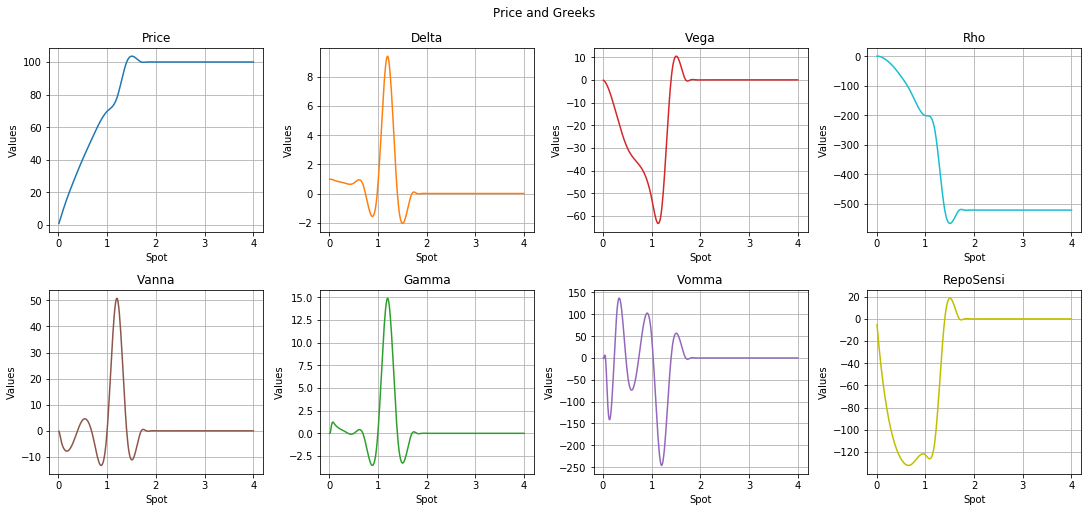

In [17]:
spotRef=100
maturity=5
acBarrierLevel=1.2
coupon=0.12
cpnBarrier=1.10
dipStrike=1
dipBarrier=0.9
isDipAmerican=True
cpnFrequency=Frequency.Annualy
isIncrementalFeature = False
isPhoenixMemory = False
nominal = 100
hasRedemption = False

autocallProduct = AutocallProduct(spotRef=spotRef,maturity=maturity,acBarrierLevel=acBarrierLevel,coupon=coupon,cpnBarrier=cpnBarrier,
                                  dipStrike=dipStrike,dipBarrier=dipBarrier,isDipAmerican=isDipAmerican,cpnFrequency=cpnFrequency,isIncrementalFeature = isIncrementalFeature,
                                isPhoenixMemory = isPhoenixMemory,Nominal=nominal,hasRedemption = hasRedemption )

sensiEngine = GenerateMCSensi(autocallProduct,AutocallPricer,bsModelStressed,nbSim = 5000,discretStep = Frequency.TriDaily)
resSensi = sensiEngine.runPriceAndGreeks(listSpots=[0.01,0.02,0.05,0.1,0.3,0.5, 0.7, 1.0,1.2,1.4,1.7,1.8,1.9,2,2.1,2.2,2.5,3,3.5,4])
mcSensiPlot(resSensi)